# Name: Mary Darkwaa Ntim                     
# Student Number:202398287

##  Task Overview

The task involves solving a 5x5 GridWorld navigation problem using two reinforcement learning algorithms: **SARSA** and **Q-learning**.

An agent must learn an optimal policy to navigate from a **start state (21)** to one of two **terminal states (1 and 5)**, while avoiding **penalty zones (states 16, 17, 19, 20)** that yield a large negative reward and reset the agent to the start. All other transitions yield a small negative reward (−1), including invalid moves (e.g., into walls), which do not change the state but still incur the penalty.

The environment is defined as follows:
- **Grid size:** 5x5 (25 states numbered 1 to 25)
- **Start state:** 21 (bottom-left, blue cell)
- **Terminal states:** 1 and 5 (top-left and top-right, black cells)
- **Penalty states:** 16, 17, 19, 20 (red cells)
- **Actions:** Up, Down, Left, Right
- **Rewards:**
  - Reaching a penalty state: −20 (and reset)
  - Reaching a normal state: −1
  - Reaching a terminal state: 0 (episode ends)
  - Invalid action: −1 (no movement)

The agent uses **ϵ-greedy** action selection to balance exploration and exploitation during learning.

The objective is to:
- Learn an optimal policy using both SARSA and Q-learning.
- Visualize the trajectory produced by each learned policy.
- Compare the policies and analyze performance during training in terms of cumulative reward over episodes.

---

##  Policy Descriptions

### SARSA — On-Policy Temporal Difference Control

SARSA (State–Action–Reward–State–Action) is an **on-policy** learning algorithm that updates Q-values using the action actually taken in the next state. It captures the influence of exploration during training.

### Q-learning — Off-Policy Temporal Difference Control

Q-learning is an **off-policy** reinforcement learning algorithm that learns the optimal policy by evaluating the maximum expected future rewards, regardless of the agent’s actual actions during training. It assumes that the agent will behave optimally in the future, even if the current behavior involves exploration.

This leads to a greedy policy that prioritizes the highest possible long-term reward.

**Update Equation:**
```python
Q[s, a] = Q[s, a] + α * (r + γ * max(Q[s']) - Q[s, a])



Training 1000 episodes with learning rate=0.1, discount factor=0.95, epsilon=0.1

=== Training SARSA ===

=== Analysis ===
SARSA trajectory (states): [21, 22, 23, 18, 13, 8, 3, 2, 1]
SARSA trajectory (coords): [(4, 0), (4, 1), (4, 2), (3, 2), (2, 2), (1, 2), (0, 2), (0, 1), (0, 0)]

Training 1000 episodes with learning rate=0.1, discount factor=0.95, epsilon=0.1

=== Training Q-Learning ===

=== Analysis ===
Q-learning trajectory (states): [21, 22, 23, 18, 13, 8, 3, 4, 5]
Q-learning trajectory (coords): [(4, 0), (4, 1), (4, 2), (3, 2), (2, 2), (1, 2), (0, 2), (0, 3), (0, 4)]


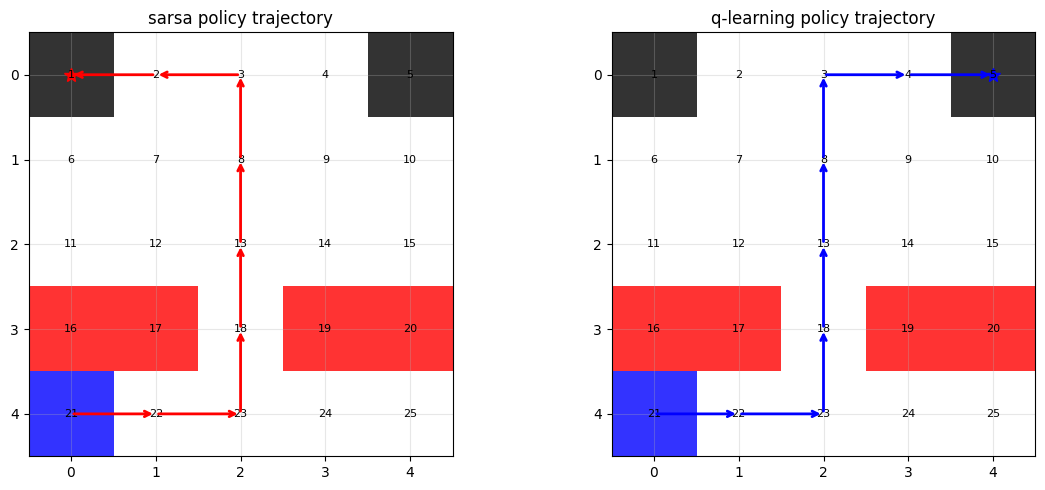

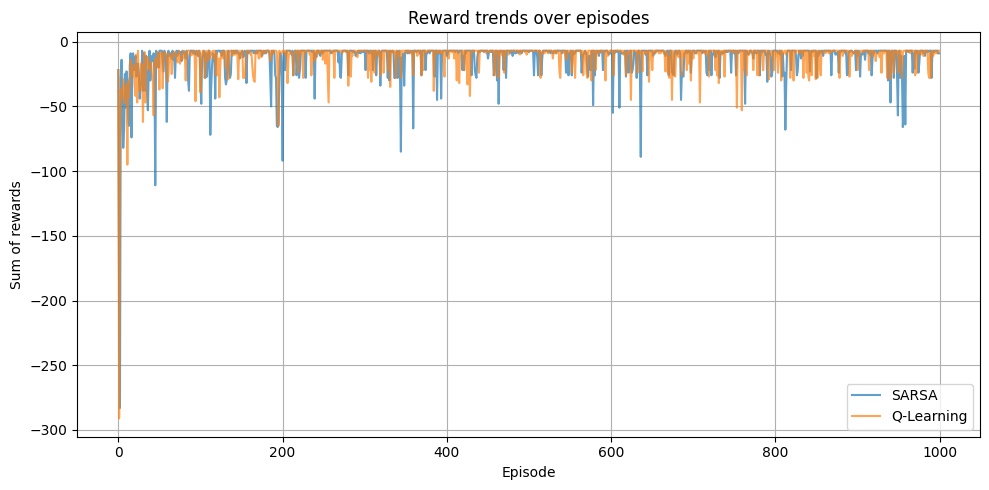

In [106]:
# grid definition
grid_size = 5
n_states = grid_size * grid_size
n_actions = 4

# state definitions
terminal_states = [1, 5]
penalty_states = [16, 17, 19, 20]
start_state = 21

# action definitions
up = 0
down = 1
left = 2
right = 3

def create_grid_layout():
    grid = np.zeros((grid_size, grid_size), dtype=int)
    for s in terminal_states:
        row, col = divmod(s - 1, grid_size)
        grid[row, col] = 1
    for s in penalty_states:
        row, col = divmod(s - 1, grid_size)
        grid[row, col] = 2
    row, col = divmod(start_state - 1, grid_size)
    grid[row, col] = 3
    return grid

def state_to_coords(state):
    return divmod(state - 1, grid_size)

def coords_to_state(row, col):
    return row * grid_size + col + 1

def is_terminal(state):
    return state in terminal_states

def get_next_state(state, action):
    row, col = state_to_coords(state)
    if action == up:
        row = max(0, row - 1)
    elif action == down:
        row = min(grid_size - 1, row + 1)
    elif action == left:
        col = max(0, col - 1)
    elif action == right:
        col = min(grid_size - 1, col + 1)
    return coords_to_state(row, col)

def get_reward(state, action, next_state):
    if next_state in terminal_states:
        return 0
    elif next_state in penalty_states:
        return -20
    else:
        return -1

import jax
import jax.numpy as jnp
from jax import random, jit
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

def create_q_table(init_value=0.0):
    return jnp.full((n_states + 1, n_actions), init_value)

def get_state_q_values(q_table, state):
    return q_table[state]

def epsilon_greedy_action(q_values, epsilon, key):
    if random.uniform(key) < epsilon:
        return random.randint(key, shape=(), minval=0, maxval=n_actions)
    return jnp.argmax(q_values)

def train_sarsa(n_episodes, alpha, gamma, epsilon, seed=0):
    q_table = create_q_table()
    rewards = []
    key = random.PRNGKey(seed)

    for ep in range(n_episodes):
        state = start_state
        ep_reward = 0
        key, subkey = random.split(key)
        q_values = get_state_q_values(q_table, state)
        action = int(epsilon_greedy_action(q_values, epsilon, subkey))

        while not is_terminal(state):
            next_state = get_next_state(state, action)
            reward = get_reward(state, action, next_state)
            ep_reward += reward

            key, subkey = random.split(key)
            next_q_values = get_state_q_values(q_table, next_state)
            next_action = int(epsilon_greedy_action(next_q_values, epsilon, subkey))

            td_target = reward + gamma * q_table[next_state, next_action]
            td_error = td_target - q_table[state, action]
            q_table = q_table.at[state, action].set(q_table[state, action] + alpha * td_error)

            state = next_state
            action = next_action

        rewards.append(ep_reward)
    return q_table, rewards

def train_q_learning(n_episodes, alpha, gamma, epsilon, seed=0):
    q_table = create_q_table()
    rewards = []
    key = random.PRNGKey(seed)

    for ep in range(n_episodes):
        state = start_state
        ep_reward = 0

        while not is_terminal(state):
            key, subkey = random.split(key)
            q_values = get_state_q_values(q_table, state)
            action = int(epsilon_greedy_action(q_values, epsilon, subkey))

            next_state = get_next_state(state, action)
            reward = get_reward(state, action, next_state)
            ep_reward += reward

            best_next_q = jnp.max(q_table[next_state])
            td_target = reward + gamma * best_next_q
            td_error = td_target - q_table[state, action]
            q_table = q_table.at[state, action].set(q_table[state, action] + alpha * td_error)

            state = next_state

        rewards.append(ep_reward)
    return q_table, rewards

def trajectory_to_coords(traj):
    return [state_to_coords(s) for s in traj]

def get_trajectory(q_table, use_epsilon, epsilon=0.1, max_steps=20, key=None):
    if key is None:
        key = random.PRNGKey(42)
    state = start_state
    trajectory = [state]

    for _ in range(max_steps):
        if is_terminal(state):
            break
        q_values = get_state_q_values(q_table, state)
        if use_epsilon:
            key, subkey = random.split(key)
            action = int(epsilon_greedy_action(q_values, epsilon, subkey))
        else:
            action = int(jnp.argmax(q_values))
        state = get_next_state(state, action)
        trajectory.append(state)
    return trajectory

def run_sarsa_experiment(n_episodes=1000, alpha=0.1, gamma=0.95, epsilon=0.1, seed=42):
    print(f"\nTraining {n_episodes} episodes with learning rate={alpha}, discount factor={gamma}, epsilon={epsilon}")
    print("\n=== Training SARSA ===")
    q_table_sarsa, rewards_sarsa = train_sarsa(n_episodes, alpha, gamma, epsilon, seed)

    print("\n=== Analysis ===")
    traj_sarsa = get_trajectory(q_table_sarsa, use_epsilon=False)
    print(f"SARSA trajectory (states): {traj_sarsa}")
    print(f"SARSA trajectory (coords): {trajectory_to_coords(traj_sarsa)}")

    return q_table_sarsa, rewards_sarsa

def run_q_learning_experiment(n_episodes=1000, alpha=0.1, gamma=0.95, epsilon=0.1, seed=42):
    print(f"\nTraining {n_episodes} episodes with learning rate={alpha}, discount factor={gamma}, epsilon={epsilon}")
    print("\n=== Training Q-Learning ===")
    q_table_q, rewards_q = train_q_learning(n_episodes, alpha, gamma, epsilon, seed)

    print("\n=== Analysis ===")
    traj_q = get_trajectory(q_table_q, use_epsilon=False)
    print(f"Q-learning trajectory (states): {traj_q}")
    print(f"Q-learning trajectory (coords): {trajectory_to_coords(traj_q)}")

    return q_table_q, rewards_q

def plot_trajectories(q_table_sarsa, q_table_q):
    grid = create_grid_layout()
    colors = ["white", "black", "red", "blue"]
    custom_cmap = ListedColormap(colors)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    traj_sarsa = trajectory_to_coords(get_trajectory(q_table_sarsa, use_epsilon=False))
    traj_q = trajectory_to_coords(get_trajectory(q_table_q, use_epsilon=False))

    coords_sarsa = np.array(traj_sarsa)
    coords_q = np.array(traj_q)

    for ax, coords, color, title in zip(
        axes, [coords_sarsa, coords_q], ["r", "b"], ["sarsa policy trajectory", "q-learning policy trajectory"]):
        ax.imshow(grid, cmap=custom_cmap, alpha=0.8)
        for state in range(1, n_states + 1):
            r, c = state_to_coords(state)
            ax.text(c, r, str(state), va='center', ha='center', fontsize=8, color='black')
        for i in range(len(coords) - 1):
            r0, c0 = coords[i]
            r1, c1 = coords[i + 1]
            ax.annotate("", xy=(c1, r1), xytext=(c0, r0), arrowprops=dict(arrowstyle="->", color=color, lw=2))
        r_last, c_last = coords[-1]
        ax.plot(c_last, r_last, marker="*", markersize=10, color=color)
        ax.set_title(title)
        ax.set_xticks(range(grid_size))
        ax.set_yticks(range(grid_size))
        ax.grid(True, alpha=0.3)
        ax.set_xlim(-0.5, grid_size - 0.5)
        ax.set_ylim(grid_size - 0.5, -0.5)

    plt.tight_layout()
    plt.show()

def plot_reward_trends(rewards_sarsa, rewards_q):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards_sarsa, label="SARSA", alpha=0.7)
    plt.plot(rewards_q, label="Q-Learning", alpha=0.7)
    plt.xlabel("Episode")
    plt.ylabel("Sum of rewards")
    plt.title("Reward trends over episodes")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

q_table_sarsa, rewards_sarsa = run_sarsa_experiment()
q_table_q, rewards_q = run_q_learning_experiment()
plot_trajectories(q_table_sarsa, q_table_q)
plot_reward_trends(rewards_sarsa, rewards_q)



**Observation:**
- The SARSA agent moves **left toward state 1** (top-left terminal) using a relatively safe route, staying far from penalty states.
- The Q-learning agent moves **right toward state 5** (top-right terminal), a **more direct but riskier path**, navigating close to penalty zones (especially state 20).

---

####  Policy Differences: Are They Similar or Different?

- The **policies are different**.
- SARSA, being on-policy, incorporates exploratory behavior during training. It produces a **safer and more conservative** policy, often avoiding paths that might lead to penalties—even if they are shorter.
- Q-learning, being off-policy, learns the **greedy optimal path** regardless of how exploration occurred. As a result, it identifies **shorter but potentially riskier** trajectories.

This explains the behavioral divergence seen in their respective trajectories: SARSA avoids red zones more cautiously, while Q-learning tolerates risky proximity if the return is high.

---

####  Episode Reward Trends

**Reward Trends Summary:**
- **SARSA:**
  - Shows gradual and stable improvement in total episode rewards.
  - Exhibits **lower variance** over time.
  - Reflects slow policy refinement due to influence from exploration.
- **Q-learning:**
  - Converges faster to better rewards.
  - Has **greater reward variance** early in training due to more aggressive value updates.
  - Eventually outperforms SARSA in terms of final average reward per episode.

**Key Insight:**
- SARSA’s on-policy updates make it **slower but safer** in environments with penalties.
- Q-learning’s off-policy updates lead to **faster convergence** and **more optimal final policy**, though at the cost of initial instability.

---

#### Remarks

- Both algorithms successfully learned an optimal policy.
- **Q-learning** reached the terminal state in **fewer steps** by aggressively seeking the highest return path.
- **SARSA** learned a policy that avoids penalizing zones more effectively due to its consideration of exploration in policy updates.
- The use of **ϵ-greedy** ensured that exploration persisted throughout training for both methods, balancing the trade-off between discovering new strategies and exploiting learned ones.

---
###  Should SARSA and Q-learning Learn Similar or Different Policies?

In theory, **the policies learned by SARSA and Q-learning can differ**, particularly in environments with penalties or stochastic transitions — as is the case in this GridWorld task.

---

###  Policy Difference Overview

| Feature                  | SARSA                          | Q-learning                      |
|--------------------------|--------------------------------|---------------------------------|
| Type                    | On-policy                      | Off-policy                      |
| Uses actual next action | Yes                         |  No (uses max Q)              |
| Behavior learned         | More cautious, risk-averse     | More aggressive, greedy         |
| Influence of exploration| Direct (from policy's behavior) | Indirect (learns optimal path)  |

---

###  Behavior in This GridWorld Task

The GridWorld environment includes:
- **Penalty zones** (states 16, 17, 19, 20) with a heavy reward of −20 and reset to the start
- **Two terminal states** (states 1 and 5)
- **Exploration strategy**: ε-greedy action selection

#### SARSA
- Being **on-policy**, SARSA updates its Q-values using the **actual action taken** in the next state.
- This results in learning a policy that reflects **exploratory behavior** during training.
- Consequently, SARSA's policy tends to **avoid risky areas** like penalty zones.
- It leads to **more conservative paths**.

#### Q-learning
- As an **off-policy** method, Q-learning updates using the **maximum Q-value** of the next state, assuming the agent always acts optimally.
- It is **unaffected by exploratory moves** during training.
- Therefore, Q-learning often finds **shorter, more aggressive paths**, even if they pass near penalty zones.

---

###  Should the Policies Be the Same?

**Not necessarily.**  
Due to their different learning strategies:

- SARSA learns what the agent does **with exploration**, leading to **risk-averse** behavior.
- Q-learning learns what the agent **should do optimally**, resulting in **greedy** exploitation.

---

###  Conclusion

The difference in policies is both **expected** and **explained** by their underlying mechanisms:
- In this environment, **SARSA** avoids risky zones due to its cautious updates.
- **Q-learning** takes a more direct route by maximizing expected rewards, even if it skirts penalties.

Thus, **the observed differences in agent trajectories between SARSA and Q-learning are correct and meaningful**.

